**Install libraries**

In [42]:
!pip install scikit-learn -q

In [32]:
!conda install seaborn -c conda-forge -y -q

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
import seaborn as sns
import pandas as pd

In [3]:
# import dataset
df = pd.read_csv("dataset.csv")

In [4]:
df.columns

Index(['LotArea', 'GrLivArea', 'Street', 'Alley', 'LotType', 'BldgType',
       'HouseStyle', 'OverallQuality', 'OverallCondition', 'YearBuilt',
       'Foundation', 'TotalBsmtSF', 'CentralAir', 'FullBath', 'HalfBath',
       'GarageType', 'GarageCars', 'GarageArea', 'YearSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [5]:
df.shape

(1460, 22)

In [6]:
df

,LotArea,GrLivArea,Street,Alley,LotType,BldgType,HouseStyle,OverallQuality,OverallCondition,YearBuilt,...,CentralAir,FullBath,HalfBath,GarageType,GarageCars,GarageArea,YearSold,SaleType,SaleCondition,SalePrice
0,8910,1194,Pave,NaN,Corner,1Fam,1Fam,6,6,1959,...,Y,1,0,BuiltIn,2,539.0,2006,WD,Normal,159500
1,1526,630,Pave,NaN,Inside,Twnhs,SFoyer,4,8,1970,...,Y,1,0,Attchd,1,286.0,2009,WD,Normal,86000
2,14598,1933,Pave,NaN,CulDSac,1Fam,2Story,6,5,2007,...,Y,2,1,BuiltIn,3,668.0,2008,WD,Normal,214000
3,7200,1040,Pave,NaN,Inside,Duplex,1Story,4,5,1949,...,N,2,0,Detchd,2,420.0,2009,WD,Normal,90000
4,5687,1716,Pave,Grvl,Inside,2fmCon,2Story,5,6,1912,...,N,2,0,NaN,0,0.0,2008,WD,Normal,135900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6000,960,Pave,NaN,Inside,1Fam,1Story,4,4,1920,...,Y,1,0,Detchd,1,308.0,2007,WD,Normal,108500
1456,12150,1795,Pave,Grvl,Inside,1Fam,1.5Fin,5,5,1954,...,N,2,0,Attchd,1,352.0,2008,WD,Normal,131500
1457,10200,1086,Pave,NaN,Inside,1Fam,1Story,5,7,1954,...,Y,1,0,Attchd,2,490.0,2010,WD,Normal,144900
1458,8400,841,Pave,NaN,Inside,1Fam,1Story,4,4,1950,...,Y,1,0,CarPort,1,294.0,2009,WD,Normal,82000


In [7]:
df.isna().sum()

LotArea                0
GrLivArea              0
Street                 0
Alley               1369
LotType                0
BldgType               0
HouseStyle             0
OverallQuality         0
OverallCondition       0
YearBuilt              0
Foundation             0
TotalBsmtSF            0
CentralAir             0
FullBath               0
HalfBath               0
GarageType            81
GarageCars             0
GarageArea            43
YearSold               0
SaleType               0
SaleCondition          0
SalePrice              0
dtype: int64

In [39]:
df.LotType.unique()

array(['Corner', 'Inside', 'CulDSac', 'FR2', 'FR3'], dtype=object)

In [38]:
df.HouseStyle.unique()

array(['1Fam', 'SFoyer', '2Story', '1Story', '2.5Unf', '2.5Fin', '1.5Fin',
       'SLvl', '1.5Unf'], dtype=object)

In [37]:
df.BldgType.unique()

array(['1Fam', 'Twnhs', 'Duplex', '2fmCon', 'TwnhsE'], dtype=object)

ValueError: could not convert string to float: '1Fam'

In [22]:
import pandas as pd

def preprocess_garage_area(df):
    """
    Preprocess the DataFrame by filling NaN values in GarageArea with 0,
    but only when GarageCars equals 0.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        
    Returns:
        pd.DataFrame: The modified DataFrame with filled GarageArea values.
    """
    # Create a boolean mask where GarageCars is 0 and GarageArea is NaN.
    condition = (df['GarageCars'] == 0) & (df['GarageArea'].isna())
    
    # Replace NaN values in GarageArea with 0 for rows matching the condition.
    df.loc[condition, 'GarageArea'] = 0
    
    return df

# Example usage:
if __name__ == "__main__":
    
    df2 = preprocess_garage_area(df)
    # print("\nAfter Preprocessing:")
    # print(df2)


In [23]:
df2.isna().sum()

LotArea                0
GrLivArea              0
Street                 0
Alley               1369
LotType                0
BldgType               0
HouseStyle             0
OverallQuality         0
OverallCondition       0
YearBuilt              0
Foundation             0
TotalBsmtSF            0
CentralAir             0
FullBath               0
HalfBath               0
GarageType            81
GarageCars             0
GarageArea            43
YearSold               0
SaleType               0
SaleCondition          0
SalePrice              0
dtype: int64

In [49]:
df.GarageType.unique()

array(['BuiltIn', 'Attchd', 'Detchd', nan, 'Basment', '2Types', 'CarPort'],
      dtype=object)

In [8]:
df.GarageArea

0       539.0
1       286.0
2       668.0
3       420.0
4         0.0
        ...  
1455    308.0
1456    352.0
1457    490.0
1458    294.0
1459    297.0
Name: GarageArea, Length: 1460, dtype: float64

In [9]:
df.GarageType

0       BuiltIn
1        Attchd
2       BuiltIn
3        Detchd
4           NaN
         ...   
1455     Detchd
1456     Attchd
1457     Attchd
1458    CarPort
1459     Attchd
Name: GarageType, Length: 1460, dtype: object

In [10]:
df.Alley

0        NaN
1        NaN
2        NaN
3        NaN
4       Grvl
        ... 
1455     NaN
1456    Grvl
1457     NaN
1458     NaN
1459     NaN
Name: Alley, Length: 1460, dtype: object

In [24]:
import pandas as pd

def correlation_garage_cars_type(df):
    """
    Computes the Pearson correlation between GarageCars and GarageType.
    
    Since GarageType is categorical, this function first fills any missing 
    values with 'Missing', then encodes the categories using factorization, 
    and finally computes the Pearson correlation coefficient.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing 'GarageCars' and 'GarageType'.
        
    Returns:
        float: The Pearson correlation coefficient between the encoded GarageType and GarageCars.
    """
    if 'GarageType' not in df.columns or 'GarageCars' not in df.columns:
        raise ValueError("DataFrame must contain columns 'GarageType' and 'GarageCars'")
    
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Fill missing GarageType values with a placeholder
    df['GarageType'] = df['GarageType'].fillna('Missing')
    
    # Factorize the GarageType column (returns tuple (codes, uniques))
    encoded_types, uniques = pd.factorize(df['GarageType'])
    
    # Compute the Pearson correlation coefficient between GarageCars and the encoded GarageType.
    correlation = pd.Series(encoded_types).corr(df['GarageCars'])
    return correlation

# Example usage:
if __name__ == "__main__":
    corr_value = correlation_garage_cars_type(df)
    print("Correlation between GarageCars and GarageType:", corr_value)


Correlation between GarageCars and GarageType: -0.41880572558894036


In [20]:
df.GarageCars.unique()

array([2, 1, 3, 0, 4])

In [25]:
df.GarageType.unique()

array(['BuiltIn', 'Attchd', 'Detchd', nan, 'Basment', '2Types', 'CarPort'],
      dtype=object)

In [17]:
for col in df.columns:
    if df[col].nunique()==1:
        print(col)

In [18]:
df[col]

0       159500
1        86000
2       214000
3        90000
4       135900
         ...  
1455    108500
1456    131500
1457    144900
1458     82000
1459    155000
Name: SalePrice, Length: 1460, dtype: int64

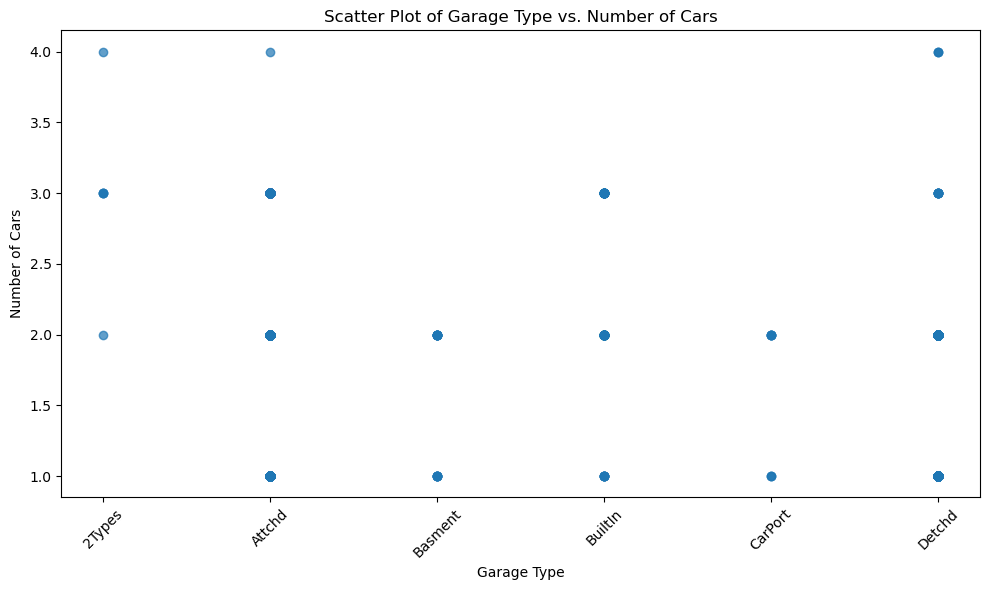

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume you already have your DataFrame loaded and it's named df
# For example:
# df = pd.read_csv('your_data.csv')

# Filter out rows where 'Garage Type' is NaN.
df_filtered = df[df['GarageType'].notna()].copy()

# Convert 'Garage Type' into categorical data and then into numeric codes.
# This creates a new column that maps each garage type to a unique numeric code.
df_filtered['GarageTypeCode'] = df_filtered['GarageType'].astype('category').cat.codes

# Create the scatter plot.
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['GarageTypeCode'], df_filtered['GarageCars'], alpha=0.7)

# Label the axes.
plt.xlabel('Garage Type')
plt.ylabel('Number of Cars')

# Replace the numeric codes with the original category names on the x-axis.
# First, get the sorted list of unique categories.
categories = df_filtered['GarageType'].astype('category').cat.categories
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)

# Add a title.
plt.title('Scatter Plot of Garage Type vs. Number of Cars')

# Display the plot.
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def build_correlation_matrix(df):
    """
    Builds a correlation matrix between features by excluding rows with missing values.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the features.
        
    Returns:
        pd.DataFrame: The correlation matrix computed on the rows with no missing values.
    """
    # Drop rows that contain any missing values.
    df_complete = df.dropna()
    
    # Compute the correlation matrix on the cleaned DataFrame.
    corr_matrix = df_complete.corr()
    
    return corr_matrix

# Example usage:
if __name__ == "__main__":
    
    corr_matrix = build_correlation_matrix(df)
    
    print("\nCorrelation Matrix (excluding rows with missing values):")
    print(corr_matrix)
    
    # Optional: visualize the correlation matrix as a heatmap.
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()


ValueError: could not convert string to float: 'Pave'

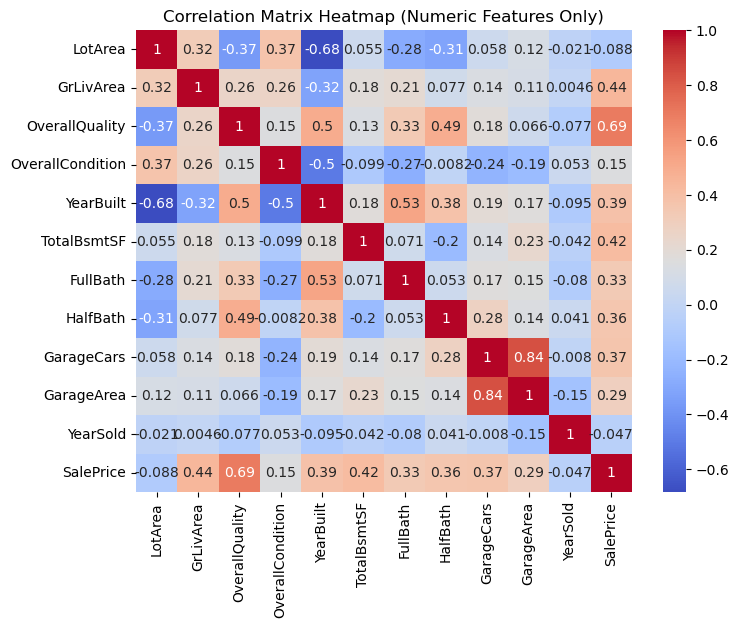

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def build_correlation_matrix(df):
    """
    Builds a correlation matrix using only numeric features, excluding rows with missing values.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing various features.
                           Non-numeric features will be automatically excluded.
        
    Returns:
        pd.DataFrame: The correlation matrix computed on the cleaned, numeric data.
    """
    # Drop rows that contain any missing values.
    df_complete = df.dropna()

    # Select only numeric columns to avoid conversion issues.
    numeric_df = df_complete.select_dtypes(include=['number'])
    
    # Compute the correlation matrix on the numeric DataFrame.
    corr_matrix = numeric_df.corr()
    
    return corr_matrix

# Example usage:
if __name__ == "__main__":
    # Build the correlation matrix.
    corr_matrix = build_correlation_matrix(df)
    
    # Optional: visualize the correlation matrix using a heatmap.
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix Heatmap (Numeric Features Only)")
    plt.show()


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def correlation_category_garagearea(df, category_column):
    """
    Computes an exploratory Pearson correlation between an encoded categorical 
    variable (e.g., BldgType or HouseStyle) and GarageArea.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        category_column (str): The name of the categorical column to encode.
        
    Returns:
        float: The Pearson correlation coefficient between the encoded category and GarageArea.
    """
    # Filter out rows where GarageArea is missing.
    df_filtered = df[df['GarageArea'].notna()].copy()
    
    # Fill any missing values in the categorical column if needed.
    df_filtered[category_column] = df_filtered[category_column].fillna("Missing")
    
    # Encode the categorical variable.
    encoder = LabelEncoder()
    encoded_category = encoder.fit_transform(df_filtered[category_column])
    
    # Compute the Pearson correlation coefficient.
    correlation = np.corrcoef(encoded_category, df_filtered['GarageArea'])[0,1]
    return correlation

# Example usage:
if __name__ == "__main__":
    corr_bldgtype = correlation_category_garagearea(df, 'BldgType')
    corr_housestyle = correlation_category_garagearea(df, 'HouseStyle')
    
    print("Exploratory correlation between BldgType and GarageArea:", corr_bldgtype)
    print("Exploratory correlation between HouseStyle and GarageArea:", corr_housestyle)


Exploratory correlation between BldgType and GarageArea: -0.055203113500306725
Exploratory correlation between HouseStyle and GarageArea: 0.16995709499780418


In [51]:
import pandas as pd
import numpy as np

# Machine learning models and utilities.
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------------------
# Assume df is your DataFrame that contains the three columns:
#  - "GarageType" (categorical: 'BuiltIn', 'Attchd', 'Detchd', np.nan, 'Basment', '2Types', 'CarPort')
#  - "GarageCars" (integer values: 0, 1, 2, 3, 4)
#  - "GarageArea" (continuous float)
# ---------------------------------------------------------------------

# For the purpose of demonstration, you might load your data like:
# df = pd.read_csv('your_data.csv')

# ==============================================================================
# 1. Model to Impute Missing "GarageType"
# ==============================================================================

# Use rows where "GarageType" and "GarageArea" are both available.
df_gtype = df[df['GarageType'].notna() & df['GarageArea'].notna()].copy()

# The features are 'GarageCars' and 'GarageArea'
X_gtype = df_gtype[['GarageCars', 'GarageArea']]

# The target variable is 'GarageType'
y_gtype = df_gtype['GarageType']

# Encode the target variable (since it is categorical)
le = LabelEncoder()
y_gtype_enc = le.fit_transform(y_gtype)

# (Optional) Split data to evaluate the model performance on a held-out set.
X_train, X_test, y_train, y_test = train_test_split(X_gtype, y_gtype_enc, test_size=0.1, random_state=0)

# Build a classifier. Here we use RandomForestClassifier as an example.
gtype_clf = RandomForestClassifier(random_state=0)
gtype_clf.fit(X_train, y_train)

# Evaluate on the test set:
accuracy = gtype_clf.score(X_test, y_test)
print("GarageType classification model accuracy: {:.2f}%".format(accuracy * 100))

# ---------------------------------------------------------------------
# Impute missing "GarageType" values (only for rows where GarageArea is available)
missing_gtype = df[df['GarageType'].isna() & df['GarageArea'].notna()]

if not missing_gtype.empty:
    X_missing_gtype = missing_gtype[['GarageCars', 'GarageArea']]
    # Predict the encoded labels and then inverse-transform to original categories.
    gtype_pred_enc = gtype_clf.predict(X_missing_gtype)
    gtype_pred = le.inverse_transform(gtype_pred_enc)
    # Save imputed values into a new column
    df.loc[X_missing_gtype.index, 'GarageType_imputed'] = gtype_pred

# ==============================================================================
# 2. Model to Impute Missing "GarageArea"
# ==============================================================================

# Use rows where "GarageArea" is available and "GarageType" is not missing.
df_garea = df[df['GarageArea'].notna() & df['GarageType'].notna()].copy()

# For this regression model:
#  - Use "GarageCars" as a numeric predictor.
#  - Use "GarageType" as a categorical predictor (one-hot encoding).
X_garea = pd.concat([df_garea[['GarageCars']], pd.get_dummies(df_garea['GarageType'], prefix='GT')], axis=1)

# Target variable is "GarageArea"
y_garea = df_garea['GarageArea']

# (Optional) Split data to evaluate performance
X_train_area, X_test_area, y_train_area, y_test_area = train_test_split(X_garea, y_garea, test_size=0.2, random_state=0)

# Build a regressor. Here, a RandomForestRegressor is used.
garea_regr = RandomForestRegressor(random_state=0)
garea_regr.fit(X_train_area, y_train_area)

# Evaluate using R² score on the test data.
r2 = garea_regr.score(X_test_area, y_test_area)
print("GarageArea regression model R² score: {:.2f}".format(r2))

# ---------------------------------------------------------------------
# Impute missing "GarageArea" (using rows that have a valid 'GarageType')
missing_garea = df[df['GarageArea'].isna() & df['GarageType'].notna()]

if not missing_garea.empty:
    # Build feature matrix for the missing rows. Use pd.get_dummies on 'GarageType'.
    X_missing_garea = pd.concat(
        [missing_garea[['GarageCars']], pd.get_dummies(missing_garea['GarageType'], prefix='GT')],
        axis=1
    )
    # Ensure the missing data features have exactly the same columns as in the training set.
    X_missing_garea = X_missing_garea.reindex(columns=X_garea.columns, fill_value=0)
    # Predict GarageArea for missing rows.
    garea_pred = garea_regr.predict(X_missing_garea)
    # Store the imputed values in a new column.
    df.loc[X_missing_garea.index, 'GarageArea_imputed'] = garea_pred

# ==============================================================================
# Optional: Show a summary of imputed values.
# ==============================================================================
print("Number of GarageType values imputed:", df['GarageType_imputed'].notna().sum())
print("Number of GarageArea values imputed:", df['GarageArea_imputed'].notna().sum())


GarageType classification model accuracy: 64.18%
GarageArea regression model R² score: 0.62
Number of GarageType values imputed: 81
Number of GarageArea values imputed: 43


In [54]:
43/df.shape[0]*100

2.945205479452055

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------------
# Assume df is your DataFrame that contains the columns:
#  - "GarageType" (categorical; some values may be missing)
#  - "GarageCars" (numeric: 0, 1, 2, 3, 4)
#  - "GarageArea" (continuous float; some values may be missing)
# ---------------------------------------------------------------------

# Prepare the data for the regression model:
# Use only rows where "GarageArea" is not missing.
df_garea = df[df['GarageArea'].notna()].copy()

# Use only "GarageCars" as the predictor.
X_garea = df_garea[['GarageCars']]

# Target variable is "GarageArea"
y_garea = df_garea['GarageArea']

# (Optional) Split the data into training and test sets to evaluate model performance.
X_train, X_test, y_train, y_test = train_test_split(X_garea, y_garea, test_size=0.2, random_state=0)

# Build and train the regressor (using RandomForestRegressor as an example).
garea_regr = RandomForestRegressor(random_state=0)
garea_regr.fit(X_train, y_train)

# Evaluate the model performance on the test set (R² score).
r2_score = garea_regr.score(X_test, y_test)
print("Regression model using only GarageCars R² score: {:.2f}".format(r2_score))

# ---------------------------------------------------------------------
# Impute missing "GarageArea" values using the trained model.
# For imputation, we use rows that are missing GarageArea.
missing_garea = df[df['GarageArea'].isna()]

if not missing_garea.empty:
    # Use only "GarageCars" for the imputation.
    X_missing = missing_garea[['GarageCars']]
    # Predict the missing GarageArea values.
    garea_imputed = garea_regr.predict(X_missing)
    # Store the imputed values in a new column.
    df.loc[X_missing.index, 'GarageArea_imputed_onlyGarageCars'] = garea_imputed

# Optional: Print a summary of the imputed values.
print("Number of GarageArea values imputed using only GarageCars:",
      df['GarageArea_imputed_onlyGarageCars'].notna().sum())

Regression model using only GarageCars R² score: 0.80
Number of GarageArea values imputed using only GarageCars: 43


Regression model using only GarageCars R² score: 0.80


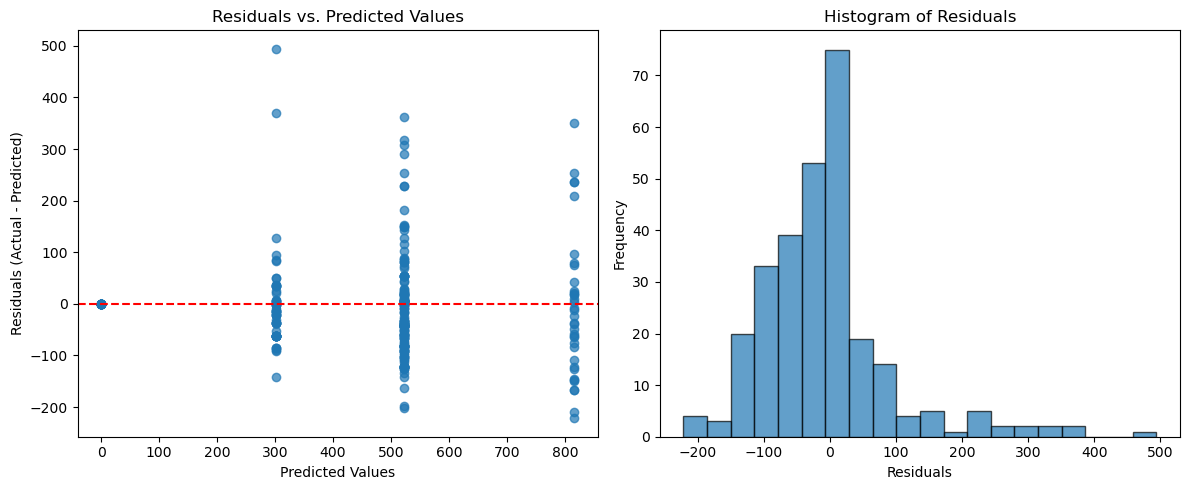

Imputed missing GarageArea values for 43 records.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def plot_residuals(model, X, y):
    """
    Plot the residuals of a regression model.
    
    Parameters:
    - model: A fitted regression model with a predict() method.
    - X: The feature matrix used to make predictions.
    - y: The actual target values.
    """
    # Get predicted values and compute residuals.
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Set up a figure with two subplots.
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Scatter plot of predicted values vs. residuals.
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')  # horizontal line at zero.
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Residuals vs. Predicted Values')
    
    # Subplot 2: Histogram of the residuals.
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Assume `df` is your DataFrame with at least the columns:
# - "GarageCars": numeric (0, 1, 2, 3, 4)
# - "GarageArea": continuous (with some missing values)
# -----------------------------------------------------------------------------

# Filter the DataFrame to only include rows where GarageArea is available.
df_garea = df[df['GarageArea'].notna()].copy()

# Use only "GarageCars" as the feature.
X_garea = df_garea[['GarageCars']]
y_garea = df_garea['GarageArea']

# Split the data into training and testing sets to evaluate the model.
X_train, X_test, y_train, y_test = train_test_split(X_garea, y_garea, test_size=0.2, random_state=0)

# Build and train the RandomForestRegressor.
garea_regr = RandomForestRegressor(random_state=0)
garea_regr.fit(X_train, y_train)

# Evaluate the model using R² score.
r2_score = garea_regr.score(X_test, y_test)
print("Regression model using only GarageCars R² score: {:.2f}".format(r2_score))

# Plot the residuals to check their pattern.
plot_residuals(garea_regr, X_test, y_test)

# -----------------------------------------------------------------------------
# (Optional) Impute missing GarageArea values using the trained model.
# -----------------------------------------------------------------------------
missing_garea = df[df['GarageArea'].isna()]
if not missing_garea.empty:
    X_missing = missing_garea[['GarageCars']]
    garea_imputed = garea_regr.predict(X_missing)
    df.loc[X_missing.index, 'GarageArea_imputed_onlyGarageCars'] = garea_imputed
    print("Imputed missing GarageArea values for {} records.".format(len(X_missing)))
else:
    print("No missing GarageArea values to impute.")


In [55]:
import pandas as pd

# Example: assume df is your DataFrame.
# for example:
# df = pd.read_csv('your_data.csv')

# Loop over each row in the DataFrame.
for index, row in df.iterrows():
    # Check if 'GarageType' is NaN using pandas' isna() function.
    if pd.isna(row['GarageType']):
        print("GarageCars:", row["GarageCars"], 
              ", BldgType:", row["BldgType"], 
              ", HouseStyle:", row["HouseStyle"])


GarageCars: 0 , BldgType: 2fmCon , HouseStyle: 2Story
GarageCars: 0 , BldgType: Duplex , HouseStyle: 1Story
GarageCars: 0 , BldgType: Duplex , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 2Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: Duplex , HouseStyle: 2Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Unf
GarageCars: 0 , BldgType: Twnhs , HouseStyle: SFoyer
GarageCars: 0 , BldgType: 2fmCon , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1.5Fin
GarageCars: 0 , BldgType: 1Fam , HouseStyle: 1Story
G

In [ ]:
import pandas as pd

# Example: assume df is your DataFrame.
# for example:
# df = pd.read_csv('your_data.csv')

# Loop over each row in the DataFrame.
for index, row in df.iterrows():
    # Check if 'GarageType' is NaN using pandas' isna() function.
    if row['GarageCars']==0:
        print("GarageType:", row["GarageType"], "GarageArea:", row["GarageArea"])

GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageType: nan GarageArea: 0.0
GarageTy

In [ ]:
import pandas as pd

def fill_missing_garage_values(df):
    """
    Fill missing values in 'GarageArea' and 'GarageType' based on the following rules:
      1. For 'GarageType': If 'GarageArea' is 0 and 'GarageType' is NaN, fill it with "No garage".
      2. For 'GarageArea': For each unique value in 'GarageCars' (expected values: 0, 1, 2, 3, 4), 
         fill missing values with the average 'GarageArea' for that group.
         
    After imputation, print the remaining number of missing values in these two columns and return the updated DataFrame.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame containing at least the columns
                           'GarageArea', 'GarageType', and 'GarageCars'.
    
    Returns:
        pd.DataFrame: The DataFrame after imputing missing values.
    """
    
    # Rule 2: For GarageArea, fill missing values based on the group average for each GarageCars value.
    # Since GarageCars has no missing values (unique values: [0, 1, 2, 3, 4]), we can compute the group mean.
    # The transform("mean") computes the group mean for each row.
    group_avg = df.groupby("GarageCars")["GarageArea"].transform("mean")
    df["GarageArea"] = df["GarageArea"].fillna(group_avg)
    
    # Rule 1: For GarageType, fill missing values with "No garage" if the corresponding GarageArea is 0.
    condition = (df["GarageArea"] == 0) & (df["GarageType"].isna())
    df.loc[condition, "GarageType"] = "No garage"
    
    # Print the number of missing values in 'GarageArea' and 'GarageType'
    print("Missing values in 'GarageArea':", df["GarageArea"].isna().sum())
    print("Missing values in 'GarageType':", df["GarageType"].isna().sum())
    
    return df

df_preprocessed = fill_missing_garage_values(df)


Missing values in 'GarageArea': 0
Missing values in 'GarageType': 0
